In [1]:
import netCDF4 as nc
import matplotlib.pyplot as plt
from matplotlib.colors import from_levels_and_colors
import numpy as np
from matplotlib import animation
from matplotlib.colors import BoundaryNorm
import matplotlib.colors as cols
import matplotlib as mpl
from mpl_toolkits.basemap import Basemap
from matplotlib import ticker, cm
import seaborn as sns
import xarray as xr
import xgcm
import pop_tools
from collections import Counter
import more_itertools

In [2]:
ds = xr.open_dataset("/work/DXL/try/B.E.13.B1850C5.ne120_t12.sehires38.003.sunway_02.pop.h.0313-09.nc")
ds

<xarray.Dataset>
Dimensions:             (d2: 2, nlat: 2400, nlon: 3600, time: 1, z_t: 62, z_t_150m: 15, z_w: 62, z_w_bot: 62, z_w_top: 62)
Coordinates:
  * time                (time) object 0313-10-01 00:00:00
  * z_t                 (z_t) float32 500.0 1.5e+03 ... 5.625e+05 5.875e+05
  * z_t_150m            (z_t_150m) float32 500.0 1.5e+03 ... 1.35e+04 1.45e+04
  * z_w                 (z_w) float32 0.0 1e+03 2e+03 ... 5.5e+05 5.75e+05
  * z_w_top             (z_w_top) float32 0.0 1e+03 2e+03 ... 5.5e+05 5.75e+05
  * z_w_bot             (z_w_bot) float32 1e+03 2e+03 3e+03 ... 5.75e+05 6e+05
    ULONG               (nlat, nlon) float64 ...
    ULAT                (nlat, nlon) float64 ...
    TLONG               (nlat, nlon) float64 ...
    TLAT                (nlat, nlon) float64 ...
Dimensions without coordinates: d2, nlat, nlon
Data variables: (12/87)
    time_bound          (time, d2) object ...
    dz                  (z_t) float32 ...
    dzw                 (z_w) float32 ...
    KMT                 (nlat, nlon) float64 ...
    KMU                 (nlat, nlon) float64 ...
    REGION_MASK         (nlat, nlon) float64 ...
    ...                  ...
    HMXL                (time, nlat, nlon) float32 ...
    XMXL                (time, nlat, nlon) float32 ...
    TMXL                (time, nlat, nlon) float32 ...
    HBLT                (time, nlat, nlon) float32 ...
    XBLT                (time, nlat, nlon) float32 ...
    TBLT                (time, nlat, nlon) float32 ...
Attributes:
    title:           B.E.13.B1850C5.ne120_t12.sehires38.003.sunway_02
    history:         none
    Conventions:     CF-1.0; http://www.cgd.ucar.edu/cms/eaton/netcdf/CF-curr...
    contents:        Diagnostic and Prognostic Variables
    source:          CCSM POP2, the CCSM Ocean Component
    revision:        $Id: tavg.F90 56176 2013-12-20 18:35:46Z mlevy@ucar.edu $
    calendar:        All years have exactly  365 days.
    start_time:      This dataset was created on 2019-11-04 at 00:40:42.6
    cell_methods:    cell_methods = time: mean ==> the variable values are av...
    nsteps_total:    66676259
    tavg_sum:        2592000.0
    tavg_sum_qflux:  2592000.0

In [3]:
grid, ds_ren = pop_tools.to_xgcm_grid_dataset(ds, periodic=False)

In [4]:
# Take topographic gradient (simple gradient over one grid cell) and move back to u-grid
dhu_dx = grid.interp( grid.diff(ds_ren.HU,'X', boundary="extend") / grid.interp(ds_ren.DXU, 'X', boundary="extend"), 'X', boundary="extend")

# Take topographic gradient (simple gradient over one grid cell) and move back to u-grid
dhu_dy = grid.interp( grid.diff(ds_ren.HU, 'Y', boundary='extend') / grid.interp(ds_ren.DYU, 'Y', boundary='extend'), 'Y', boundary='extend')

# Magnitude of the topographic slope (to normalise the topographic gradient)
topographic_slope_magnitude = np.sqrt(dhu_dx**2 + dhu_dy**2)

In [5]:
# Along-slope velocity
u_along1 = ds_ren.UVEL * dhu_dy / topographic_slope_magnitude 
u_along2 = - ds_ren.VVEL * dhu_dx / topographic_slope_magnitude
u_along = u_along1 + u_along2

# Load the data
#u_along = u_along.load()

# Similarly, we can calculate the cross-slope velocity:
v_cross = ds_ren.UVEL*dhu_dx/topographic_slope_magnitude + ds_ren.VVEL*dhu_dy/topographic_slope_magnitude

In [6]:
data = np.load('lonlat222.npz')
lon_along_contour222 = data['lon_along_contour222']
lat_along_contour222 = data['lat_along_contour222']

In [7]:
data = np.load('lonlat.npz')

In [8]:
lon_along_contour = data['lon_along_contour']
lat_along_contour = data['lat_along_contour']
num_points = data['num_points']

In [9]:
# Define empty array
u_along_contour = np.zeros((62, len(lon_along_contour)))
v_along_contour = np.zeros((62, len(lon_along_contour)))

###
#d_along_contour = np.zeros((len(lon_along_contour)))
# Finally select velocity along contour 
for ii in range(len(lon_along_contour)):
    u_along_contour[:,ii] = u_along.sel(nlon_u=lon_along_contour[ii], method='nearest').sel(nlat_u=lat_along_contour[ii], method='nearest')
    v_along_contour[:,ii] = v_cross.sel(nlon_u=lon_along_contour[ii], method='nearest').sel(nlat_u=lat_along_contour[ii], method='nearest')


In [16]:
ds_ren.ULONG[400,:]

<xarray.DataArray 'ULONG' (nlon_u: 3600)>
array([-109.9, -109.8, -109.7, ..., -110.2, -110.1, -110. ])
Coordinates:
    ULONG    (nlon_u) float64 -109.9 -109.8 -109.7 ... -110.2 -110.1 -110.0
    ULAT     (nlon_u) float64 -61.31 -61.31 -61.31 ... -61.31 -61.31 -61.31
  * nlon_u   (nlon_u) int64 1 2 3 4 5 6 7 ... 3594 3595 3596 3597 3598 3599 3600
    nlat_u   int64 401
Attributes:
    long_name:  array of u-grid longitudes
    units:      degrees_east
    grid_loc:   2220

In [22]:
lon_along_contour222

array([250.05, 250.15, 250.25, ..., 249.85, 249.95, 250.05])

In [28]:
scale_max = 0.05
ft_size   = 16

/home/dxl/.conda/envs/myenv/lib/python3.6/site-packages/ipykernel_launcher.py:3: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  This is separate from the ipykernel package so we can avoid doing imports until
/home/dxl/.conda/envs/myenv/lib/python3.6/site-packages/ipykernel_launcher.py:15: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  from ipykernel import kernelapp as app


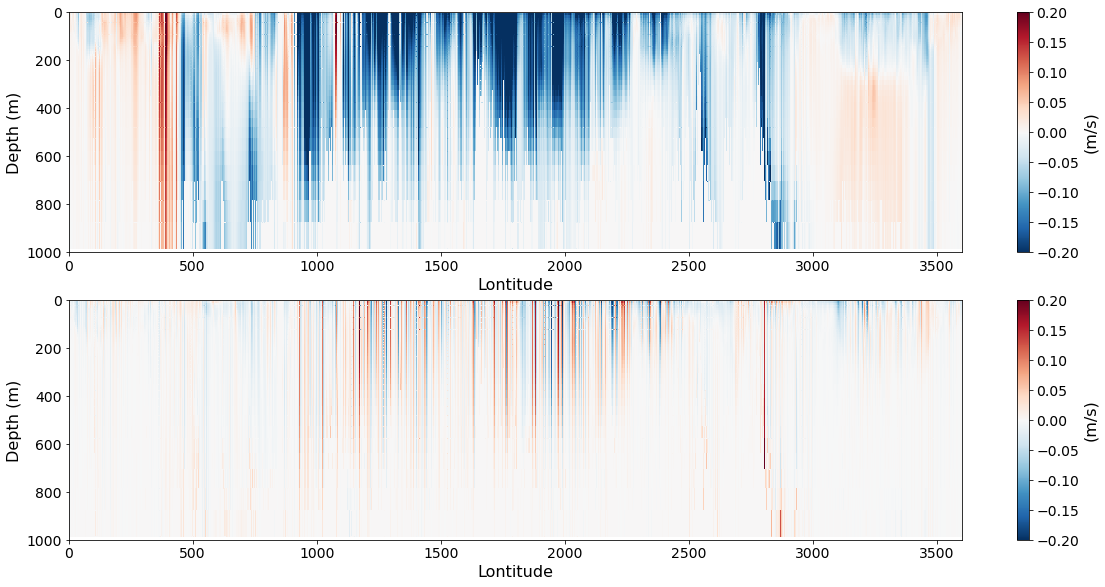

In [33]:
fig = plt.figure(figsize=(20,15))
ax = plt.subplot(3, 1, 1)
plt.pcolormesh(lon_along_contour, ds_ren.z_t[:40]/100, u_along_contour[:40,:]/100, vmin=-(4*scale_max), vmax=4*scale_max, cmap='RdBu_r')
plt.xlabel('Lontitude', fontsize=ft_size)
cbar = plt.colorbar()
cbar.ax.tick_params(labelsize=ft_size-2)
cbar.set_ticks(np.arange(-4*scale_max, 4*scale_max+scale_max, scale_max))
cbar.set_label('(m/s)', fontsize=ft_size)
#plt.title(title_name, fontsize=ft_size, loc='left')
ax.tick_params(labelsize=ft_size-2)
plt.ylim(1000, 0)
plt.ylabel('Depth (m)', fontsize=ft_size)

ax = plt.subplot(3, 1, 2)
plt.pcolormesh(lon_along_contour, ds_ren.z_t[:40]/100, v_along_contour[:40,:]/100, vmin=-(4*scale_max), vmax=4*scale_max, cmap='RdBu_r')
plt.xlabel('Lontitude', fontsize=ft_size)
cbar = plt.colorbar()
cbar.ax.tick_params(labelsize=ft_size-2)
cbar.set_ticks(np.arange(-4*scale_max, 4*scale_max+scale_max, scale_max))
cbar.set_label('(m/s)', fontsize=ft_size)
#
#plt.xticks(lon_along_contour[0:4410:500], lon_along_contour222[0:4410:500])
#plt.title(title_name, fontsize=ft_size, loc='left')
ax.tick_params(labelsize=ft_size-2)
plt.ylim(1000, 0)
plt.ylabel('Depth (m)', fontsize=ft_size)
plt.savefig("speed.png",bbox_inches='tight')